#Single product and stochastic environment

Parameters :

*   T rounds
*   N number of types of products
*   P set of possible prices
*   B production capacity
*   n_customers max of possible customers
*   n_trials





In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Stochastic environment :

This PricingEnvironment class models a simplified sales environment where the demand and revenue depend on the chosen price:

*   conversion_probability: a function mapping a price p_t to the probability that a single customer makes a purchase.
*   cost: the unit production (or acquisition) cost.



In [ ]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost)*d_t
        return d_t, r_t


##1. Single product and no inventory constraints

The UCB1Agent implements the UCB1 bandit algorithm :


*   pull_arm(): plays each arm once, then selects the arm with the highest upper confidence bound (mean reward + exploration bonus).
*   update(r_t): updates the average reward and counts for the chosen arm, then increments time.

In [ ]:
#MA prob we just need to discretize the arms

class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0

    # need to play each arm once then update the upper confidence bound
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.t+1)/(self.N_pulls + 1e-6))
            self.a_t = np.argmax(ucbs)
        return self.a_t

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

At first we observe the following graph with:


*   Blue curve (Expected Demand curve): the theoretical demand (expected number of sales) at each price, given the conversion probability.

*   Orange curve (Estimated Demand curve): one random realization of demand, sampled from a binomial distribution with the same probabilities.

*   Green curve (Profit curve): the expected profit for each price, i.e.
(
𝑝
−
cost
)
×
expected demand
(p−cost)×expected demand.

*    Red dashed line: the optimal (clairvoyant) price that maximizes profit.




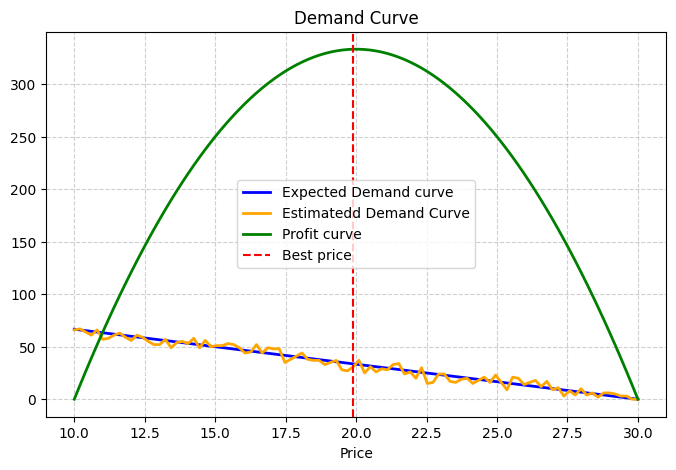

In [ ]:
T = 10000
K = 100

prices = np.linspace(10,30,K) # 100 actions!
cost = 10
conversion_probability = lambda p: 1-p/30

n_customers = 100 # I assume the number of customers arriving is the same everyday (for now, in general this is not true)

reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer
demand_curve = n_customers * conversion_probability(prices)
estimated_demand_curve = np.random.binomial(n_customers, conversion_probability(prices))

# let's compute the clairvoyant
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

plt.figure(figsize=(8, 5))
plt.plot(prices, demand_curve, label="Expected Demand curve", linewidth=2, color="blue")
plt.plot(prices, estimated_demand_curve, label="Estimatedd Demand Curve", linewidth=2, color="orange")
plt.plot(prices, profit_curve, label="Profit curve", linewidth=2, color="green")
plt.axvline(best_price, color="red", linestyle="--", label="Best price")
plt.xlabel("Price")
plt.title("Demand Curve")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

First experiment :
*     T = 10000
*     K = 100
*     n_trials = 100
*     cost = 10
*     conversion_probability = lambda p: 1-p/30

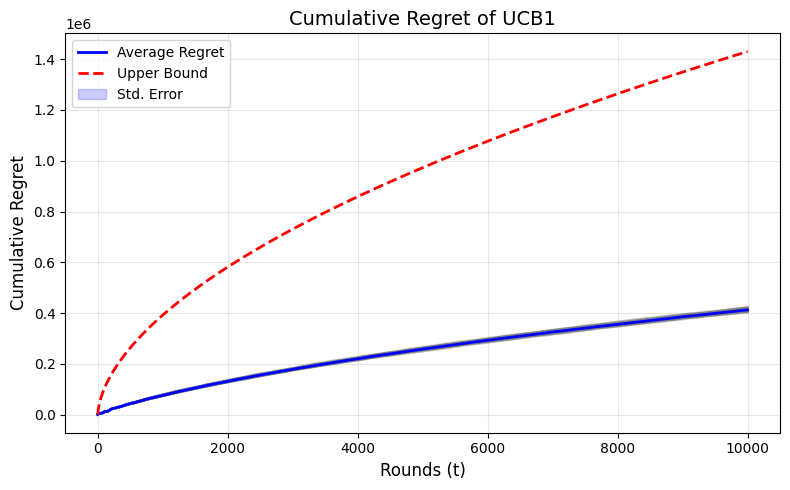

In [ ]:
n_trials = 100

regret_per_trial = []
regret_ratio_trials = []

best = 0
l_rt = 0

for seed in range(n_trials):
    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

    # Use the *max achievable profit per round* as reward range
    ucb_agent = UCB1Agent(K, T, range=max(profit_curve))

    agent_rewards = []

    for t in range(T):
        pi_t = ucb_agent.pull_arm()      # the agent returns the index
        p_t = prices[pi_t]              # actual price
        d_t, r_t = env.round(p_t, n_customers)
        ucb_agent.update(r_t)

        if r_t > l_rt :
            best = p_t

        agent_rewards.append(r_t)

    agent_rewards = np.array(agent_rewards)

    # Cumulative regret
    cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)
    regret_per_trial.append(cumulative_regret)

    # Define regret ratio as final cumulative regret over clairvoyant reward
    regret_ratio_trials.append(cumulative_regret / (np.arange(1, T+1)))

# Convert to arrays
regret_per_trial = np.array(regret_per_trial)
regret_ratio_trials = np.array(regret_ratio_trials) # Convert to array
avg_regret_ratio = regret_ratio_trials.mean(axis=0) # Calculate mean across trials
regret_ratio_sd = regret_ratio_trials.std(axis=0) # Calculate std dev across trials
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

# theorethical curve
t_values = np.arange(1,T+1)
R = max(profit_curve)  # max achievable expected profit per round (clairvoyant per-round)
bound = R * np.sqrt(2 * K * t_values * np.log(t_values))

# Plot
plt.figure(figsize=(8,5))
for i in range(n_trials):
    plt.plot(np.arange(T), regret_per_trial[i], alpha=0.2, color="gray")

plt.plot(np.arange(T), average_regret, color="blue", lw=2, label='Average Regret')
plt.plot(np.arange(T), bound, color="red", lw=2, linestyle="--", label='Upper Bound')
plt.fill_between(np.arange(T),
                 average_regret - regret_sd/np.sqrt(n_trials),
                 average_regret + regret_sd/np.sqrt(n_trials),
                 color="blue", alpha=0.2, label='Std. Error')

plt.title('Cumulative Regret of UCB1', fontsize=14)
plt.xlabel('Rounds (t)', fontsize=12)
plt.ylabel('Cumulative Regret', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Best price found from the agent is {best}")
print(f"Best price found from the clairvoyant is {best_price}")

Best price found from the agent is 16.86868686868687
Best price found from the clairvoyant is 19.8989898989899


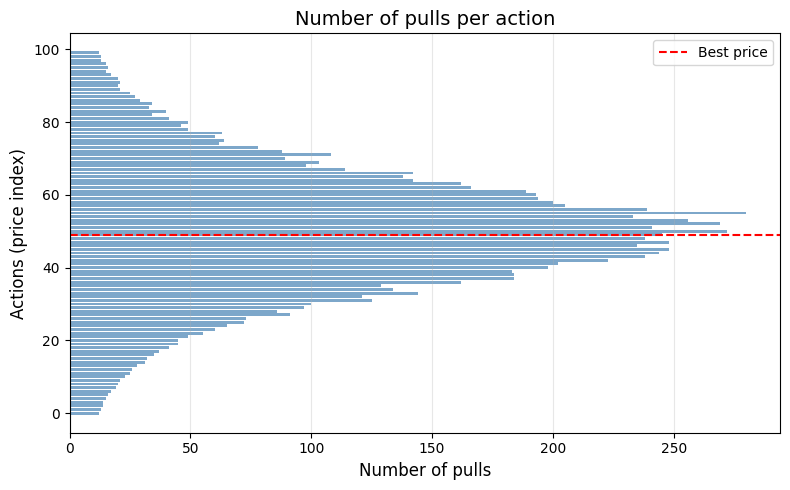

In [ ]:
# --- 2. Number of Pulls for Each Action ---
plt.figure(figsize=(8,5))
plt.barh(np.arange(K), ucb_agent.N_pulls, color="steelblue", alpha=0.7)
plt.axhline(best_price_index, color='red', linestyle="--", label='Best price')
plt.ylabel('Actions (price index)', fontsize=12)
plt.xlabel('Number of pulls', fontsize=12)
plt.title('Number of pulls per action', fontsize=14)
plt.legend()
plt.grid(alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

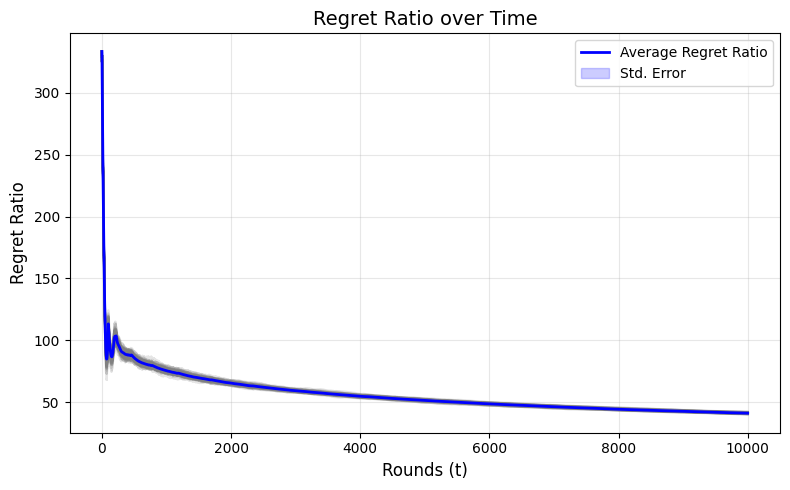

In [ ]:
# Plot
plt.figure(figsize=(8,5))
for i in range(n_trials):
    plt.plot(np.arange(T), regret_ratio_trials[i], alpha=0.2, color="gray")

plt.plot(np.arange(T), avg_regret_ratio, color="blue", lw=2, label="Average Regret Ratio")
plt.fill_between(np.arange(T),
                 avg_regret_ratio - regret_ratio_sd/np.sqrt(n_trials),
                 avg_regret_ratio + regret_ratio_sd/np.sqrt(n_trials),
                 color="blue", alpha=0.2, label="Std. Error")

plt.title("Regret Ratio over Time", fontsize=14)
plt.xlabel("Rounds (t)", fontsize=12)
plt.ylabel("Regret Ratio", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Adding inventory constraints

In this version a new variable is added at the set of initial parameters :

*   I  inventory constraint



The UCB1Agent_constraints extends the UCB1 bandit algorithm with an inventory limit:

*   pull_arm() :  If no inventory remains: returns -1 (no arm pulled), otherwise: plays each arm once, then selects the arm with the highest UCB.

*    update(r_t, d_t) : updates average reward and pull count if an arm was played, decreases inventory by the number of items sold (up to remaining stock), increments time.

In [ ]:
#MA prob we just need to discretize the arms

class UCB1Agent_constraints:
    def __init__(self, K, I, T, range=1):
        self.K = K
        self.T = T
        self.inventory = I
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0

    # need to play each arm once then update the upper confidence bound
    def pull_arm(self):
        if self.inventory < 1:
            self.a_t = -1 # Use a special value to indicate no arm was pulled for pricing
            return 0 # Return a price that results in no sales (e.g., index 0 or a very high price)
        if self.t < self.K:
            self.a_t = self.t
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.t+1)/(self.N_pulls + 1e-6))
            self.a_t = np.argmax(ucbs)
        return self.a_t

    def update(self, r_t, d_t):
        if self.a_t != -1: # Only update if a valid arm was pulled
            self.N_pulls[self.a_t] += 1
            self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
            self.inventory -= min(d_t, self.inventory)
        self.t += 1

First experiment :
*     T = 10000
*     K = 100
*     n_trials = 100
*     cost = 10
*     conversion_probability = lambda p: 1-p/30
*     I = 500000

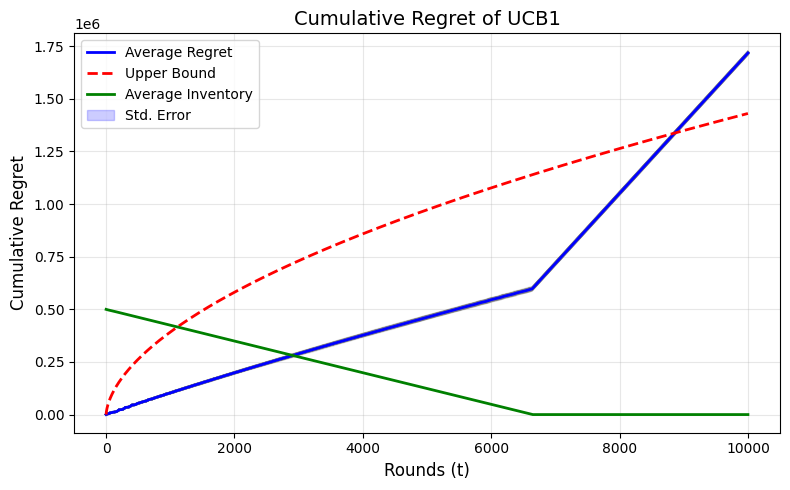

In [ ]:
I = 500000

n_trials = 100

regret_per_trial = []
inventory_overall = np.zeros(T)

for seed in range(n_trials):
    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
    ucb_agent = UCB1Agent_constraints(K, I, T, range=maximum_profit)

    agent_rewards = np.array([])
    inventory_per_trial = []

    cumulative_regret = 0
    regret_ratio_per_trial = []

    for t in range(T):
        pi_t_index = ucb_agent.pull_arm() ## the agent returns the index!!
        if pi_t_index != -1: # Check if a valid arm was pulled
            p_t = prices[pi_t_index] # I get the actual price
            demanded_d_t, r_t = env.round(p_t, n_customers)
            actual_d_t = min(demanded_d_t, ucb_agent.inventory)
            ucb_agent.update(r_t, actual_d_t)


        else:
            p_t = prices[0] # Or any price that would result in 0 sales
            d_t = 0
            r_t = 0

        ucb_agent.update(r_t, d_t)
        inventory_per_trial.append(ucb_agent.inventory)
        agent_rewards = np.append(agent_rewards, r_t)

    if seed != 0:
        inventory_per_trial = np.array(inventory_per_trial)
        for i in range(T):
            inventory_overall[i] = inventory_overall[i] * seed
            inventory_overall[i] += inventory_per_trial[i]
            inventory_overall[i] /= (seed+1)
    else:
        inventory_overall = inventory_per_trial.copy()

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)
    regret_ratio_per_trial.append(cumulative_regret / (np.arange(1, T+1)))


regret_per_trial = np.array(regret_per_trial)
regret_ratio_trials = np.array(regret_ratio_trials) # Convert to array
avg_regret_ratio = regret_ratio_trials.mean(axis=0) # Calculate mean across trials
regret_ratio_sd = regret_ratio_trials.std(axis=0) # Calculate std dev across trials
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

# theorethical curve
t_values = np.arange(1,T+1)
R = max(profit_curve)  # max achievable expected profit per round (clairvoyant per-round)
bound = R * np.sqrt(2 * K * t_values * np.log(t_values))

# Plot
plt.figure(figsize=(8,5))
for i in range(n_trials):
    plt.plot(np.arange(T), regret_per_trial[i], alpha=0.2, color="gray")

plt.plot(np.arange(T), average_regret, color="blue", lw=2, label='Average Regret')
plt.plot(np.arange(T), bound, color="red", lw=2, linestyle="--", label='Upper Bound')
plt.plot(np.arange(T), inventory_overall, color="green", lw=2, label="Average Inventory")
plt.fill_between(np.arange(T),
                 average_regret - regret_sd/np.sqrt(n_trials),
                 average_regret + regret_sd/np.sqrt(n_trials),
                 color="blue", alpha=0.2, label='Std. Error')

plt.title('Cumulative Regret of UCB1', fontsize=14)
plt.xlabel('Rounds (t)', fontsize=12)
plt.ylabel('Cumulative Regret', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


It's possible to notice that the regret increases rapidly when the inventory is depleted since the clairvoyant still sells the product whether the agent cannot.

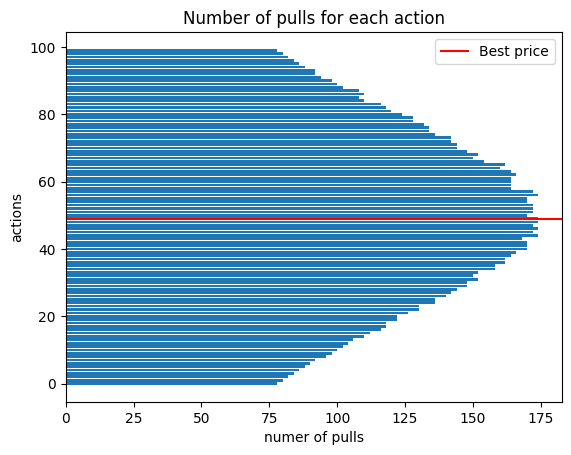

In [ ]:
plt.figure()
plt.barh(np.arange(K), ucb_agent.N_pulls) # Use K instead of 100 directly
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

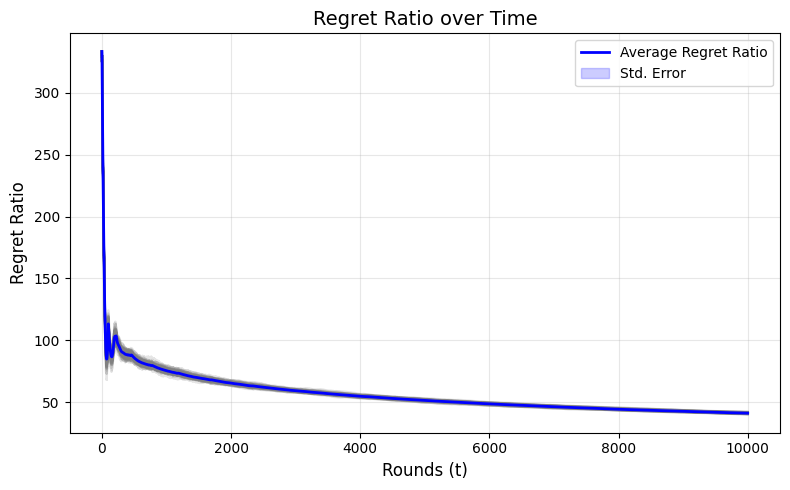

In [ ]:
# Plot
plt.figure(figsize=(8,5))
for i in range(n_trials):
    plt.plot(np.arange(T), regret_ratio_trials[i], alpha=0.2, color="gray")

plt.plot(np.arange(T), avg_regret_ratio, color="blue", lw=2, label="Average Regret Ratio")
plt.fill_between(np.arange(T),
                 avg_regret_ratio - regret_ratio_sd/np.sqrt(n_trials),
                 avg_regret_ratio + regret_ratio_sd/np.sqrt(n_trials),
                 color="blue", alpha=0.2, label="Std. Error")

plt.title("Regret Ratio over Time", fontsize=14)
plt.xlabel("Rounds (t)", fontsize=12)
plt.ylabel("Regret Ratio", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Second experiment :
*     T = 1000
*     K = 100
*     n_trials = 100
*     cost = 10
*     conversion_probability = lambda p: 1-p/20
*     I = 500000

/tmp/ipython-input-2021748057.py:84: RuntimeWarning: divide by zero encountered in log
  bound = R * np.sqrt(2 * K * t_values * np.log(t_values))
/tmp/ipython-input-2021748057.py:84: RuntimeWarning: invalid value encountered in multiply
  bound = R * np.sqrt(2 * K * t_values * np.log(t_values))


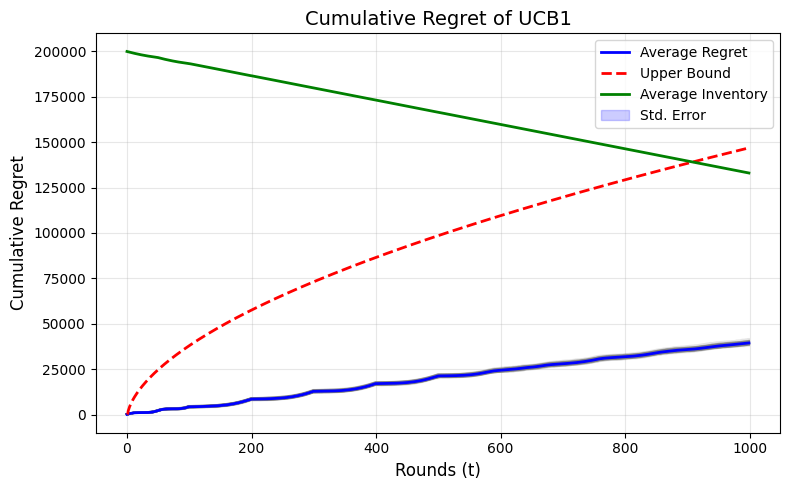

In [ ]:
T = 1000
K = 100

prices = np.linspace(10,20,K) # 100 actions!
cost = 10
conversion_probability = lambda p: 1-p/20

n_customers = 100 # I assume the number of customers arriving is the same everyday (for now, in general this is not true)
I = 200000 ## if we put 100000 we get same results with no constraints

reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

# let's compute the clairvoyant
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

n_trials = 100

regret_per_trial = []
inventory_overall = np.zeros(T)
regret_ratio_trials = [] # Initialize as a list

for seed in range(n_trials):
    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
    ucb_agent = UCB1Agent_constraints(K, I, T, range=maximum_profit)

    agent_rewards = np.array([])
    inventory_per_trial = []

    cumulative_regret = 0
    regret_ratio_per_trial = []

    for t in range(T):
        pi_t_index = ucb_agent.pull_arm() ## the agent returns the index!!
        if pi_t_index != -1: # Check if a valid arm was pulled
            p_t = prices[pi_t_index] # I get the actual price
            demanded_d_t, r_t = env.round(p_t, n_customers)
            actual_d_t = min(demanded_d_t, ucb_agent.inventory)
            ucb_agent.update(r_t, actual_d_t)


        else:
            p_t = prices[0] # Or any price that would result in 0 sales
            d_t = 0
            r_t = 0

        ucb_agent.update(r_t, d_t)
        inventory_per_trial.append(ucb_agent.inventory)
        agent_rewards = np.append(agent_rewards, r_t)

        # Append the regret ratio for the current trial and round
        cumulative_regret += (expected_clairvoyant_rewards[t] - r_t)
        regret_ratio_per_trial.append(cumulative_regret / (t + 1))


    if seed != 0:
        inventory_per_trial = np.array(inventory_per_trial)
        for i in range(T):
            inventory_overall[i] = inventory_overall[i] * seed
            inventory_overall[i] += inventory_per_trial[i]
            inventory_overall[i] /= (seed+1)
    else:
        inventory_overall = inventory_per_trial.copy()

    regret_per_trial.append(np.cumsum(expected_clairvoyant_rewards-agent_rewards)) # Append cumulative regret for the trial
    regret_ratio_trials.append(regret_ratio_per_trial) # Append the list of regret ratios for the trial


# Convert to arrays after the loop
regret_per_trial = np.array(regret_per_trial)
regret_ratio_trials = np.array(regret_ratio_trials) # Convert to array
avg_regret_ratio = regret_ratio_trials.mean(axis=0) # Calculate mean across trials
regret_ratio_sd = regret_ratio_trials.std(axis=0) # Calculate std dev across trials
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

# theorethical curve
t_values = np.arange(T)
R = max(profit_curve)  # max achievable expected profit per round (clairvoyant per-round)
bound = R * np.sqrt(2 * K * t_values * np.log(t_values))

# Plot
plt.figure(figsize=(8,5))
for i in range(n_trials):
    plt.plot(np.arange(T), regret_per_trial[i], alpha=0.2, color="gray")

plt.plot(np.arange(T), average_regret, color="blue", lw=2, label='Average Regret')
plt.plot(np.arange(T), bound, color="red", lw=2, linestyle="--", label='Upper Bound')
plt.plot(np.arange(T), inventory_overall, color="green", lw=2, label="Average Inventory")
plt.fill_between(np.arange(T),
                 average_regret - regret_sd/np.sqrt(n_trials),
                 average_regret + regret_sd/np.sqrt(n_trials),
                 color="blue", alpha=0.2, label='Std. Error')

plt.title('Cumulative Regret of UCB1', fontsize=14)
plt.xlabel('Rounds (t)', fontsize=12)
plt.ylabel('Cumulative Regret', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

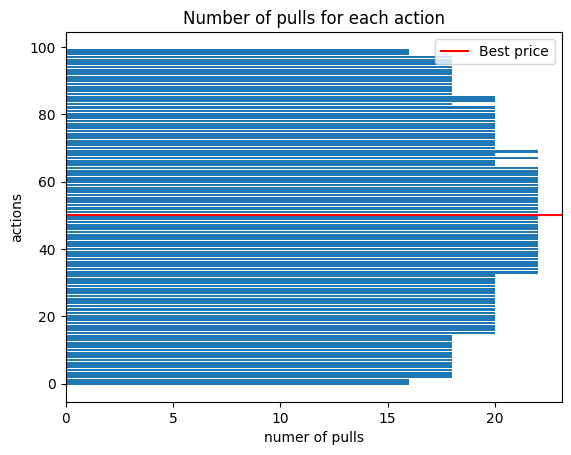

In [ ]:
plt.figure()
plt.barh(np.arange(K), ucb_agent.N_pulls) # Use K instead of 100 directly
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

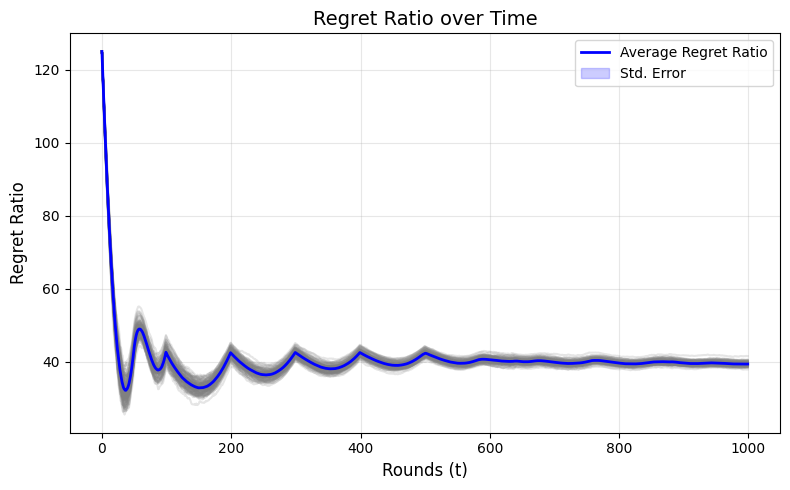

In [ ]:
# Plot
plt.figure(figsize=(8,5))
for i in range(n_trials):
    plt.plot(np.arange(T), regret_ratio_trials[i], alpha=0.2, color="gray")

plt.plot(np.arange(T), avg_regret_ratio, color="blue", lw=2, label="Average Regret Ratio")
plt.fill_between(np.arange(T),
                 avg_regret_ratio - regret_ratio_sd/np.sqrt(n_trials),
                 avg_regret_ratio + regret_ratio_sd/np.sqrt(n_trials),
                 color="blue", alpha=0.2, label="Std. Error")

plt.title("Regret Ratio over Time", fontsize=14)
plt.xlabel("Rounds (t)", fontsize=12)
plt.ylabel("Regret Ratio", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The results of the second experiment appear less balanced or "linear" compared to the first one.  
This can be explained by several factors:
- The number of rounds is relatively small, so randomness has a stronger effect.  
- The agent has had less opportunity to explore all actions, which can skew the results.  
- Inventory or demand fluctuations may introduce variability that is not yet averaged out.  

With more rounds (or repeated runs), the results would likely stabilize and better reflect the underlying trends.